# Отчет по линейной регрессии

## 1. Введение

Цель работы: изучить основы и построить простейшие модели линейной регрессии. Обучить модель на реальных данных и оценить ее качество. 


In [ ]:
import os
import pandas as pd

# Загрузка датасета
# Определяем базовую директорию для данных относительно текущей рабочей директории.
# Предполагается, что папка 'house-prices-advanced-regression-techniques' находится в той же директории, что и ноутбук.
data_base_dir = os.path.join(os.getcwd(), 'house-prices-advanced-regression-techniques')

train_csv_path = os.path.join(data_base_dir, 'train.csv')
test_csv_path = os.path.join(data_base_dir, 'test.csv')
sample_submission_csv_path = os.path.join(data_base_dir, 'sample_submission.csv')

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
sample_submission_df = pd.read_csv(sample_submission_csv_path)

print("Размер тренировочного датасета:", train_df.shape)
print("Размер тестового датасета:", test_df.shape)

print("\nПервые 5 строк тренировочного датасета:")
print(train_df.head())


Размер тренировочного датасета: (1460, 81)
Размер тестового датасета: (1459, 80)

Первые 5 строк тренировочного датасета:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...

## 2. Анализ данных

Рассмотрим датасет, покажем распределения признаков и корреляционную матрицу.



Общая информация о тренировочном датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQ

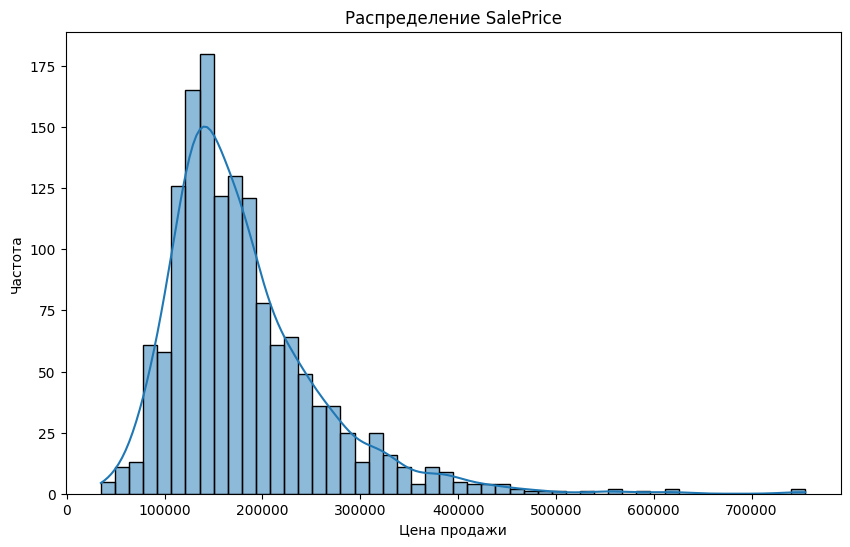

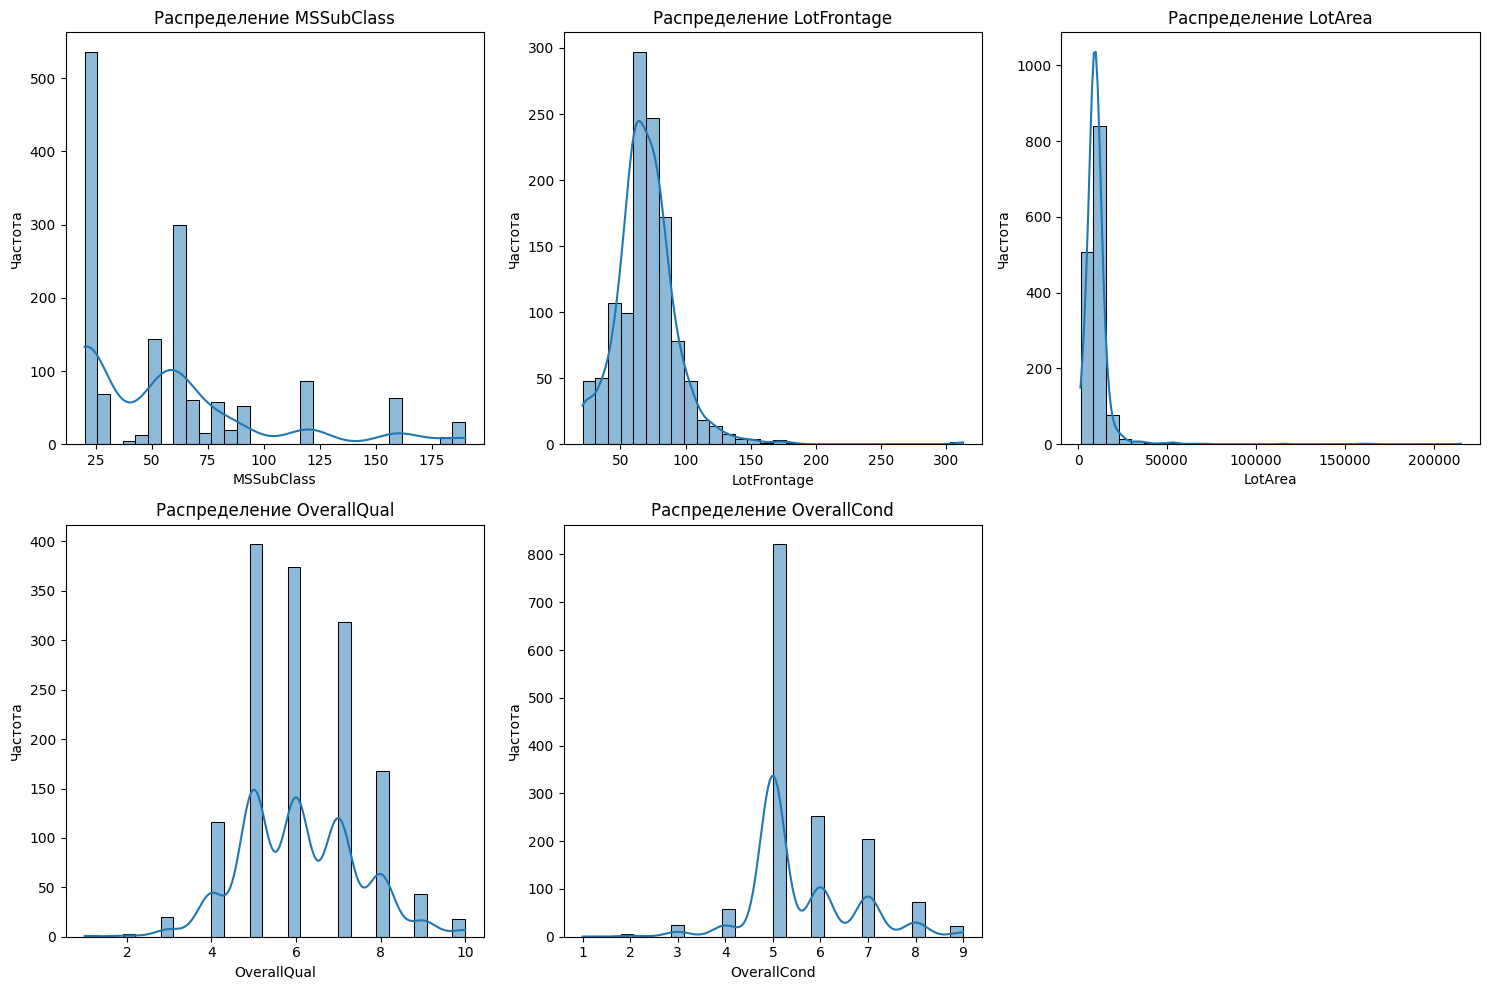

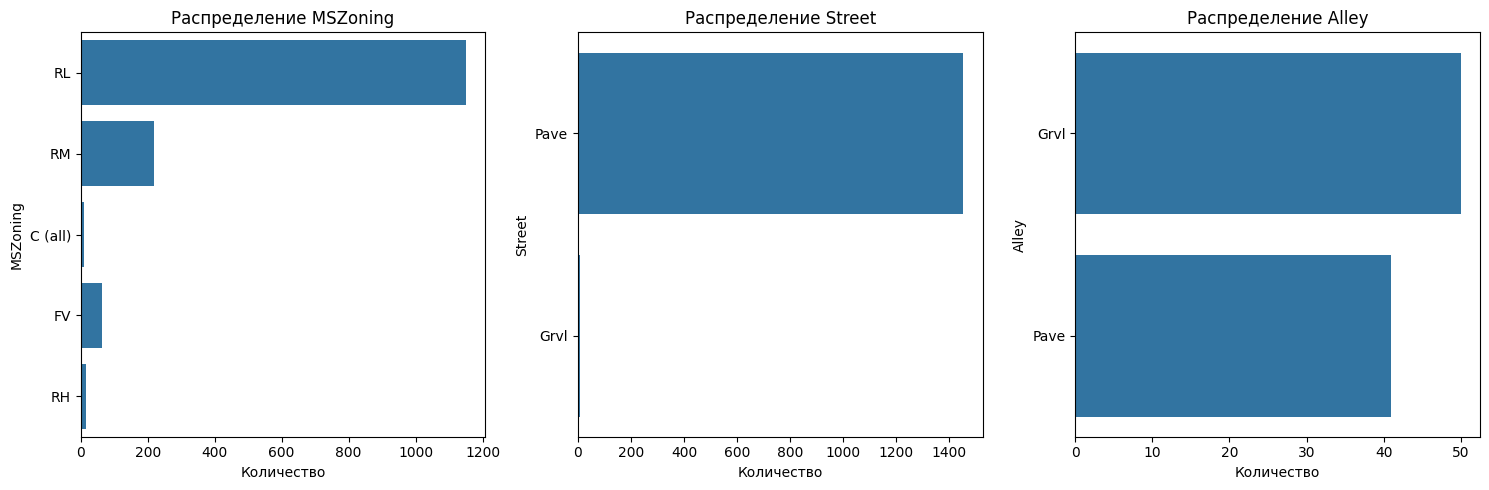

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Первичный анализ данных
print("\nОбщая информация о тренировочном датасете:")
print(train_df.info())

print("\nСтатистическое описание тренировочного датасета:")
print(train_df.describe())

# Визуализация распределения целевой переменной (SalePrice)
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='SalePrice', kde=True, bins=50)
plt.title('Распределение SalePrice')
plt.xlabel('Цена продажи')
plt.ylabel('Частота')
plt.show()

# Визуализация распределения числовых признаков
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.drop(['Id', 'SalePrice'])
selected_numeric_cols = numeric_cols[:5] if len(numeric_cols) > 5 else numeric_cols

plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_numeric_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data=train_df, x=col, kde=True, bins=30)
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
plt.tight_layout()
plt.show()

# Визуализация категориальных признаков
categorical_cols = train_df.select_dtypes(include=['object']).columns
selected_categorical_cols = categorical_cols[:3] if len(categorical_cols) > 3 else categorical_cols

plt.figure(figsize=(15, 5))
for i, col in enumerate(selected_categorical_cols):
    plt.subplot(1, 3, i + 1)
    sns.countplot(data=train_df, y=col)
    plt.title(f'Распределение {col}')
    plt.xlabel('Количество')
    plt.ylabel(col)
plt.tight_layout()
plt.show()


## 3. Подготовка данных

Подробно изложим процедуры предобработки данных: нормализация, заполнение пропусков, разделение выборки на train/test.


In [20]:

# Объединяем тренировочный и тестовый датасеты для обработки.
all_data = pd.concat((train_df.drop(['SalePrice'], axis=1), test_df)).reset_index(drop=True)
all_data.drop('Id', axis=1, inplace=True)
print(f"Размер объединенного датасета: {all_data.shape}")

# Обработка пропущенных значений
missing_data = all_data.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
missing_percent = (all_data.isnull().sum() / len(all_data)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

missing_info = pd.DataFrame({'Missing Count': missing_data, 'Missing Percent': missing_percent})
print("\nПропущенные значения в объединенном датасете:")
print(missing_info)

# Заполнение пропусков (NaN -> 'None' или 0)
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFullBath', 'BsmtHalfBath', 
            'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'MasVnrArea'):
    all_data[col] = all_data[col].fillna(0)

for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType'):
    all_data[col] = all_data[col].fillna(str(all_data[col].mode()[0]))

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
all_data['Functional'] = all_data['Functional'].fillna('Typ')
all_data = all_data.drop(['Utilities'], axis=1)

# Проверка пропусков после обработки
missing_data_after = all_data.isnull().sum()
missing_data_after = missing_data_after[missing_data_after > 0]

if missing_data_after.empty:
    print("\nВсе пропущенные значения обработаны.")
else:
    print("\nПропущенные значения после обработки:")
    print(missing_data_after)

# Кодирование категориальных переменных
print("\nКодирование категориальных переменных...")
all_data = pd.get_dummies(all_data)
print(f"Размер датасета после One-Hot Encoding: {all_data.shape}")

# Разделение на тренировочный и тестовый датасеты
X = all_data[:len(train_df)]
X_test = all_data[len(train_df):]
y = train_df['SalePrice']

print(f"\nРазмер X (тренировочные признаки): {X.shape}")
print(f"Размер y (целевая переменная): {y.shape}")
print(f"Размер X_test (тестовые признаки): {X_test.shape}")


Размер объединенного датасета: (2919, 79)

Пропущенные значения в объединенном датасете:
              Missing Count  Missing Percent
PoolQC                 2909        99.657417
MiscFeature            2814        96.402878
Alley                  2721        93.216855
Fence                  2348        80.438506
MasVnrType             1766        60.500171
FireplaceQu            1420        48.646797
LotFrontage             486        16.649538
GarageQual              159         5.447071
GarageYrBlt             159         5.447071
GarageCond              159         5.447071
GarageFinish            159         5.447071
GarageType              157         5.378554
BsmtExposure             82         2.809181
BsmtCond                 82         2.809181
BsmtQual                 81         2.774923
BsmtFinType2             80         2.740665
BsmtFinType1             79         2.706406
MasVnrArea               23         0.787941
MSZoning                  4         0.137033
BsmtFullBat

## 4. Ход работы

Опишем выбранные варианты реализации регрессии до устранения мультиколлинеарности, рассчитаем метрики (RMSE, R², MAPE), покажем устранение мультиколлинеарности с помощью PCA и сравним результаты до и после.


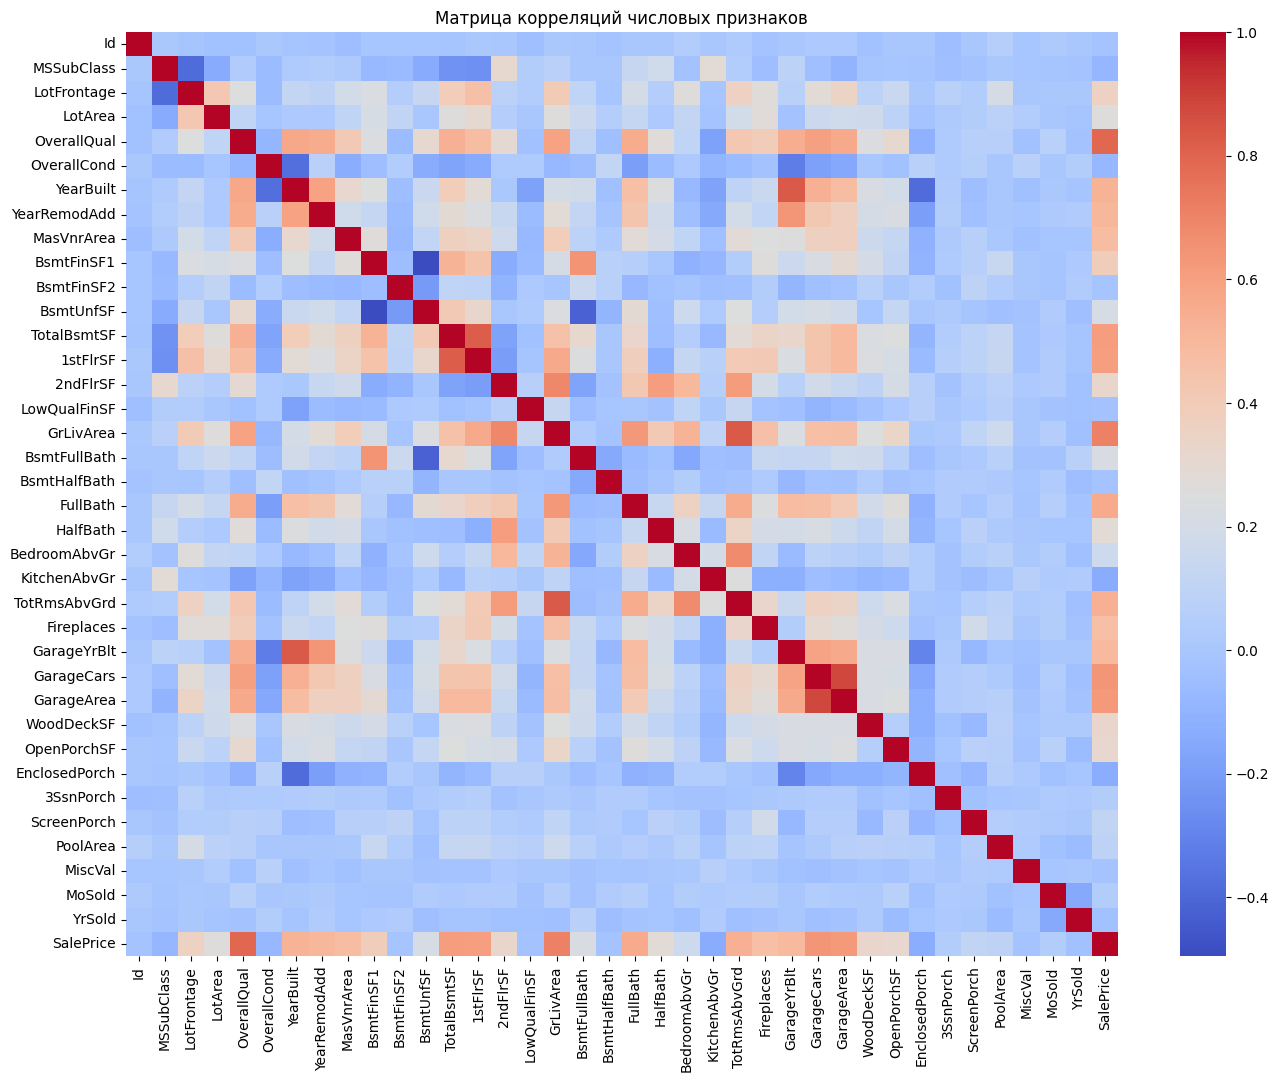


VIF-коэффициенты для признаков:
                   feature  VIF
299  SaleCondition_Partial  inf
298   SaleCondition_Normal  inf
297   SaleCondition_Family  inf
296   SaleCondition_Alloca  inf
295  SaleCondition_AdjLand  inf
294  SaleCondition_Abnorml  inf
277            Fence_MnPrv  inf
276             Fence_GdWo  inf
275            Fence_GdPrv  inf
274            PoolQC_None  inf
273              PoolQC_Gd  inf
272              PoolQC_Fa  inf
271              PoolQC_Ex  inf
270           PavedDrive_Y  inf
269           PavedDrive_P  inf
268           PavedDrive_N  inf
267          GarageCond_TA  inf
266          GarageCond_Po  inf
265        GarageCond_None  inf
264          GarageCond_Gd  inf

Выводы о мультиколлинеарности:
Признаки с VIF > 5 (или 10) указывают на наличие мультиколлинеарности.


In [21]:
# Матрица корреляций и VIF-коэффициенты

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Расчет матрицы корреляций
plt.figure(figsize=(16, 12))
sns.heatmap(train_df.corr(numeric_only=True), cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Матрица корреляций числовых признаков')
plt.show()

# Удаление столбцов с постоянным значением (проблема для VIF)
X_filtered = X.loc[:, X.apply(pd.Series.nunique) != 1]

# Расчет VIF-коэффициентов
# Добавление константы для расчета VIF
X_vif = add_constant(X_filtered)
X_vif_df = pd.DataFrame(X_vif, columns=X_filtered.columns.tolist() + ['const'])

# Удаляем константу перед расчетом VIF
X_vif_no_const = X_vif_df.drop('const', axis=1)

# Преобразование в числовой формат и обработка NaN перед расчетом VIF
X_vif_numeric = X_vif_no_const.apply(pd.to_numeric, errors='coerce')
X_vif_numeric = X_vif_numeric.fillna(X_vif_numeric.median()) # Заполнение NaN медианой

# Преобразование булевых столбцов в int
for col in X_vif_numeric.select_dtypes(include=['bool']).columns:
    X_vif_numeric[col] = X_vif_numeric[col].astype(int)

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_numeric, i) 
                   for i in range(len(X_vif_numeric.columns))]

# Сортировка по VIF
vif_data = vif_data.sort_values(by='VIF', ascending=False)

print("\nVIF-коэффициенты для признаков:")
print(vif_data.head(20))

# Выводы о мультиколлинеарности
print("\nВыводы о мультиколлинеарности:")
print("Признаки с VIF > 5 (или 10) указывают на наличие мультиколлинеарности.")

In [22]:
# Построение регрессионных моделей, разделение выборки и оценка качества

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Функция для расчета MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Делим данные на тренировочную и тестовую выборки
X_train, X_test_split, y_train, y_test_split = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер тренировочной выборки (X_train): {X_train.shape}")
print(f"Размер тестовой выборки (X_test_split): {X_test_split.shape}")

# Нормализация признаков
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_split_scaled = scaler.transform(X_test_split)

# Определение моделей
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nОбучение модели: {name}")
    
    # Кросс-валидация
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=kf))
    r2_scores = cross_val_score(model, X_train_scaled, y_train, scoring='r2', cv=kf)
    
    print(f"  RMSE на кросс-валидации: {rmse_scores.mean():.2f} (+/- {rmse_scores.std():.2f})")
    print(f"  R² на кросс-валидации: {r2_scores.mean():.2f} (+/- {r2_scores.std():.2f})")
    
    # Обучение и оценка на тестовых данных
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_split_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test_split, y_pred))
    r2 = r2_score(y_test_split, y_pred)
    mape = mean_absolute_percentage_error(y_test_split, y_pred)
    
    results[name] = {'RMSE': rmse, 'R²': r2, 'MAPE': mape}
    
    print(f"  RMSE на тестовой выборке: {rmse:.2f}")
    print(f"  R² на тестовой выборке: {r2:.2f}")
    print(f"  MAPE на тестовой выборке: {mape:.2f}%")

print("\n\nСводка результатов моделей:")
results_df = pd.DataFrame(results).T
print(results_df)


Размер тренировочной выборки (X_train): (1168, 300)
Размер тестовой выборки (X_test_split): (292, 300)

Обучение модели: Linear Regression
  RMSE на кросс-валидации: 39828.06 (+/- 12015.07)
  R² на кросс-валидации: 0.70 (+/- 0.19)
  RMSE на тестовой выборке: 65028.34
  R² на тестовой выборке: 0.45
  MAPE на тестовой выборке: 12.82%

Обучение модели: Ridge Regression
  RMSE на кросс-валидации: 35984.48 (+/- 7526.30)
  R² на кросс-валидации: 0.78 (+/- 0.08)
  RMSE на тестовой выборке: 29789.78
  R² на тестовой выборке: 0.88
  MAPE на тестовой выборке: 11.50%


Сводка результатов моделей:
                           RMSE        R²       MAPE
Linear Regression  65028.343172  0.448695  12.823911
Ridge Regression   29789.778635  0.884303  11.499667


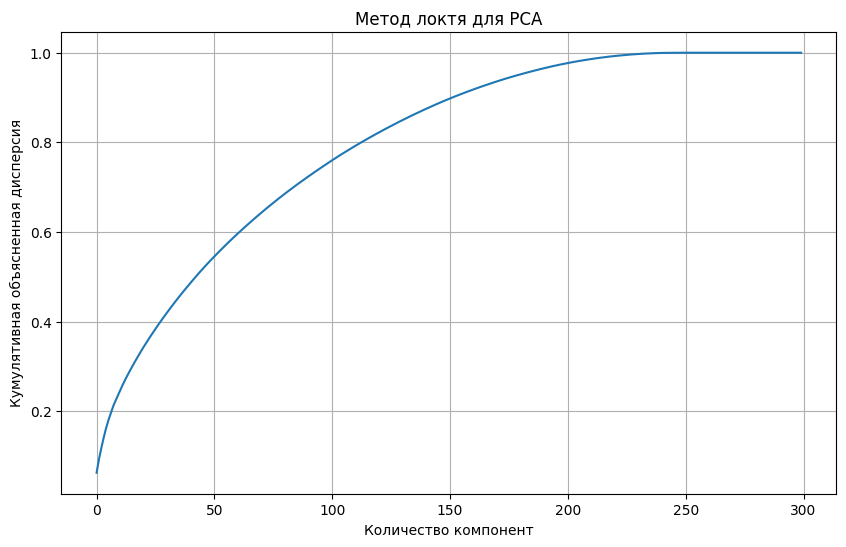


Количество главных компонент для объяснения 95% дисперсии: 180
Размерность данных после PCA: (1460, 180)
Размер тренировочной выборки после PCA (X_train_pca): (1168, 180)
Размер тестовой выборки после PCA (X_test_split_pca): (292, 180)


In [23]:
# Устранение мультиколлинеарности и снижение размерности признаков с помощью PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Масштабирование данных перед PCA
X_scaled = scaler.fit_transform(X)

# Применение PCA
pca = PCA().fit(X_scaled)

# График метода локтя для определения числа компонент
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Количество компонент')
plt.ylabel('Кумулятивная объясненная дисперсия')
plt.title('Метод локтя для PCA')
plt.grid(True)
plt.show()

# Выбор числа компонент (95% дисперсии)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"\nКоличество главных компонент для объяснения 95% дисперсии: {n_components}")

pca_final = PCA(n_components=n_components)
X_pca = pca_final.fit_transform(X_scaled)

print(f"Размерность данных после PCA: {X_pca.shape}")

# Разделение данных после PCA на выборки
X_train_pca, X_test_split_pca, y_train_pca, y_test_split_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

print(f"Размер тренировочной выборки после PCA (X_train_pca): {X_train_pca.shape}")
print(f"Размер тестовой выборки после PCA (X_test_split_pca): {X_test_split_pca.shape}")


In [24]:
# Построение регрессионных моделей на данных после PCA и сравнение результатов

# Модели для обучения на PCA-данных
models_pca = {
    'Linear Regression (PCA)': LinearRegression(),
    'Ridge Regression (PCA)': Ridge(random_state=42)
}

results_pca = {}

for name, model in models_pca.items():
    print(f"\nОбучение модели: {name}")
    
    # Кросс-валидация
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores_pca = np.sqrt(-cross_val_score(model, X_train_pca, y_train_pca, scoring='neg_mean_squared_error', cv=kf))
    r2_scores_pca = cross_val_score(model, X_train_pca, y_train_pca, scoring='r2', cv=kf)
    
    print(f"  RMSE на кросс-валидации (PCA): {rmse_scores_pca.mean():.2f} (+/- {rmse_scores_pca.std():.2f})")
    print(f"  R² на кросс-валидации (PCA): {r2_scores_pca.mean():.2f} (+/- {r2_scores_pca.std():.2f})")
    
    # Обучение и оценка на тестовых данных
    model.fit(X_train_pca, y_train_pca)
    y_pred_pca = model.predict(X_test_split_pca)
    
    rmse_pca = np.sqrt(mean_squared_error(y_test_split_pca, y_pred_pca))
    r2_pca = r2_score(y_test_split_pca, y_pred_pca)
    mape_pca = mean_absolute_percentage_error(y_test_split_pca, y_pred_pca)
    
    results_pca[name] = {'RMSE': rmse_pca, 'R²': r2_pca, 'MAPE': mape_pca}
    
    print(f"  RMSE на тестовой выборке (PCA): {rmse_pca:.2f}")
    print(f"  R² на тестовой выборке (PCA): {r2_pca:.2f}")
    print(f"  MAPE на тестовой выборке (PCA): {mape_pca:.2f}%")

# Сводка результатов моделей (до и после PCA)
print("\n\nСводка результатов моделей (до и после PCA):")
all_results_df = pd.concat([results_df, pd.DataFrame(results_pca).T])
print(all_results_df.sort_values(by='R²', ascending=False))



Обучение модели: Linear Regression (PCA)
  RMSE на кросс-валидации (PCA): 59557.70 (+/- 35531.99)
  R² на кросс-валидации (PCA): 0.23 (+/- 0.85)
  RMSE на тестовой выборке (PCA): 37356.80
  R² на тестовой выборке (PCA): 0.82
  MAPE на тестовой выборке (PCA): 13.14%

Обучение модели: Ridge Regression (PCA)
  RMSE на кросс-валидации (PCA): 56038.24 (+/- 30116.43)
  R² на кросс-валидации (PCA): 0.35 (+/- 0.65)
  RMSE на тестовой выборке (PCA): 37138.26
  R² на тестовой выборке (PCA): 0.82
  MAPE на тестовой выборке (PCA): 13.12%


Сводка результатов моделей (до и после PCA):
                                 RMSE        R²       MAPE
Ridge Regression         29789.778635  0.884303  11.499667
Ridge Regression (PCA)   37138.260637  0.820184  13.121966
Linear Regression (PCA)  37356.804338  0.818061  13.140433
Linear Regression        65028.343172  0.448695  12.823911


## 5. Заключение

Выводы о проделанной работе, основываясь на результатах анализа и моделирования. Сравнение эффективности моделей до и после применения PCA, а также общие наблюдения по датасету и методам регрессии.


## 6. Список источников

*   Kaggle: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
*   Pandas Documentation: [https://pandas.pydata.org/docs/](https://pandas.pydata.org/docs/)
*   Matplotlib Documentation: [https://matplotlib.org/stable/contents.html](https://matplotlib.org/stable/contents.html)
*   Seaborn Documentation: [https://seaborn.pydata.org/](https://seaborn.pydata.org/)
*   Scikit-learn Documentation: [https://scikit-learn.org/stable/](https://scikit-learn.org/stable/)
*   Statsmodels Documentation: [https://www.statsmodels.org/stable/index.html](https://www.statsmodels.org/stable/index.html)

## 7. Приложение

Полный листинг программного кода.
